# Credit Risk Analysis


We will first import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_score

After importing the libraries , let upload the loan data

In [3]:
df=pd.read_csv(r"C:\Users\olilo\Downloads\Task 3 and 4_Loan_Data.csv")

# Drop customer_id column as it won't contribute to the prediction
df.drop(columns=['customer_id'], inplace=True)
dt=df.copy()

In [4]:
dt

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,5221.545193,3915.471226,78039.38546,5,605,0
1,5,1958.928726,8228.752520,26648.43525,2,572,1
2,0,3363.009259,2027.830850,65866.71246,4,602,0
3,0,4766.648001,2501.730397,74356.88347,5,612,0
4,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...
9995,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,0,3288.901666,1043.099660,50929.37206,2,647,0


The first step after loadind the data is to explore the data

# Exploratory Data Analysis

Basic Statistics:
       credit_lines_outstanding  loan_amt_outstanding  total_debt_outstanding  \
count              10000.000000          10000.000000            10000.000000   
mean                   1.461200           4159.677034             8718.916797   
std                    1.743846           1421.399078             6627.164762   
min                    0.000000             46.783973               31.652732   
25%                    0.000000           3154.235371             4199.836020   
50%                    1.000000           4052.377228             6732.407217   
75%                    2.000000           5052.898103            11272.263740   
max                    5.000000          10750.677810            43688.784100   

              income  years_employed    fico_score       default  
count   10000.000000    10000.000000  10000.000000  10000.000000  
mean    70039.901401        4.552800    637.557700      0.185100  
std     20072.214143        1.566862     60.657906 

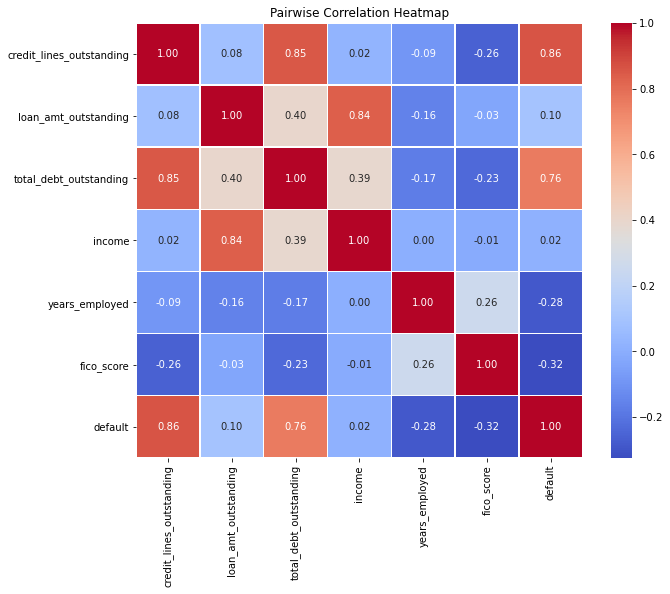

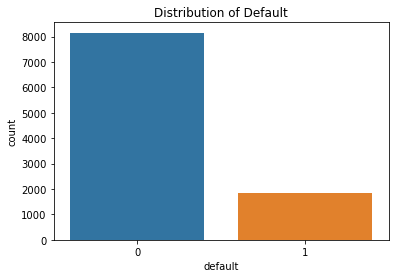

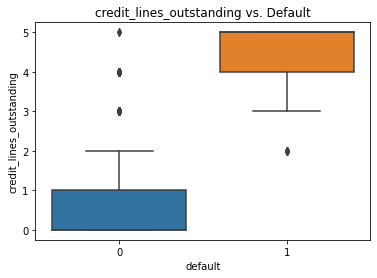

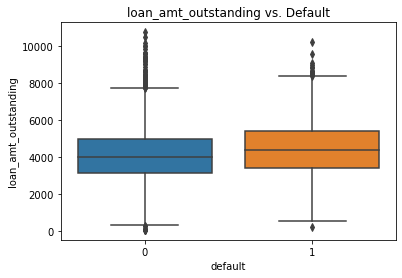

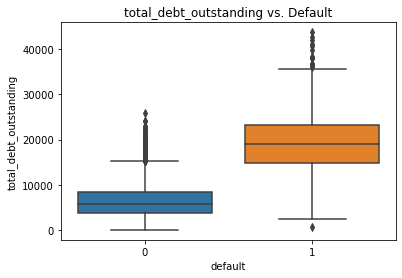

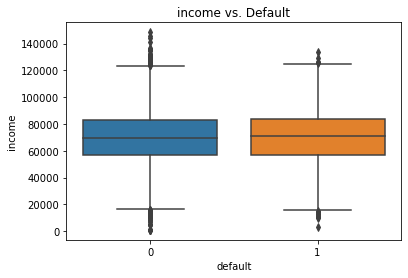

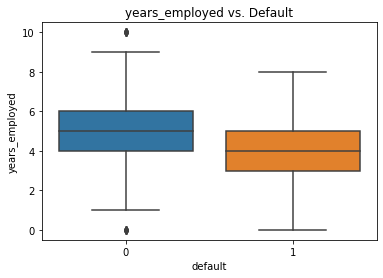

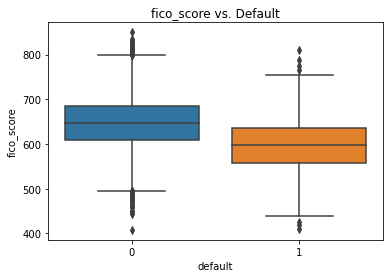

In [5]:
# Explore the data with EDA
def perform_eda(df):
    # Basic statistics
    print("Basic Statistics:")
    print(df.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Pairwise correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Pairwise Correlation Heatmap")
    plt.show()

    # Univariate analysis of the target variable (default)
    plt.figure(figsize=(6, 4))
    sns.countplot(x='default', data=df)
    plt.title("Distribution of Default")
    plt.show()
 # Bivariate analysis: Default vs. other features
    features = df.drop(columns=['default']).columns
    for feature in features:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='default', y=feature, data=df)
        plt.title(f"{feature} vs. Default")
        plt.show()

# Perform EDA
perform_eda(df)

From the data analysis we found out that :

    - we may have some multicolllinearity problem
    
    - The distribution of default is unbalanced
    
    - the total loan outstanding is one of the biggest effect of defaulting

from here I decided to to compute the weight of evidence and Information value to understand the predictive power of each independant variable

In [7]:
# Function to calculate WOE for a continuous variable
def calculate_woe_continuous(dt, feature, target, bins=10):
    # Check if the feature is numeric (continuous) or not (categorical)
    if pd.api.types.is_numeric_dtype(dt[feature]):
        # Calculate the bins manually for the continuous variable
        dt['bins'], bin_edges = pd.cut(dt[feature], bins, retbins=True, duplicates='drop', include_lowest=True)
    
    # Calculate the number of events (defaults) and non-events (non-defaults) in each bin
    grouped = dt.groupby('bins').agg({
        feature: 'count',
        target: 'sum'
    })
    
    # Calculate the percentage of events and non-events in each bin
    grouped['event_pct'] = grouped[target] / grouped[feature]
    grouped['non_event_pct'] = 1 - grouped['event_pct']
    
    # Calculate WOE by taking the natural logarithm of division (with a small offset to avoid divide-by-zero)
    grouped['woe'] = np.log((grouped['non_event_pct'] + 1e-9) / (grouped['event_pct'] + 1e-9))
    
    woe_dict = grouped['woe'].to_dict()
    woe_data = grouped[['woe']].rename(columns={'woe': 'woe_' + feature})
    
    # Reset index to avoid overlapping index when concatenating DataFrames
    woe_data.reset_index(drop=True, inplace=True)
    
    return woe_data, woe_dict

# Calculate WOE and IV for each feature in the dataset
woe_data = pd.DataFrame()
iv_values = {}

for feature in dt.drop(columns=['default']).columns:
    woe_feature_data, woe_dict = calculate_woe_continuous(dt, feature, target='default')

    woe_data = pd.concat([woe_data, woe_feature_data], axis=1)

    if not feature.startswith('woe_') and feature != 'bins':  # Exclude "woe_" features and "bins"
        # Calculate IV for the original feature based on WOE
        event_pct = dt['default'].sum() / dt['default'].count()
        non_event_pct = 1 - event_pct
        iv = np.sum((np.array(list(woe_dict.values())) - np.log((non_event_pct + 1e-9) / (event_pct + 1e-9))) * (dt.groupby('bins').count()['default'] / dt.shape[0]))
        iv_values[feature] = iv

# Display IV score for each original feature
print("Information Value (IV) for each feature:")
print(pd.Series(iv_values))



Information Value (IV) for each feature:
credit_lines_outstanding    12.026096
loan_amt_outstanding         0.020835
total_debt_outstanding       1.064116
income                       0.003133
years_employed               0.304898
fico_score                   0.223547
dtype: float64


We can see here that the information value confirm the correlation between default and credit lines outsanding

# Prepocessing 

During EDA we found out that the default feature was imbalance so we will mke sure to work on that after slipting the data

In [8]:
def preprocess_data(df):
    
    # Split the data into features (X) and target (y)
    X = df.drop(columns=['default'])
    y = df['default']
  
    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # Apply SMOTE to the training data to handle class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    return X_train_resampled, X_test, y_train_resampled, y_test



In [9]:
# Call the preprocess_data function
X_train_resampled, X_test, y_train_resampled, y_test = preprocess_data(df)

# Now you can use the resampled training data
print(X_train_resampled)

       credit_lines_outstanding  loan_amt_outstanding  total_debt_outstanding  \
0                             0           3005.328746             4216.415038   
1                             1           4717.704748             8760.954045   
2                             0           5394.537878             5024.768703   
3                             1           5367.416056             8101.373570   
4                             1           3622.450370             7329.325832   
...                         ...                   ...                     ...   
12989                         5           3120.403821            14255.949800   
12990                         5           6237.018601            22342.745460   
12991                         4           3863.324310            15941.741641   
12992                         4           2822.614035            12058.765215   
12993                         5           5334.894545            25503.422502   

             income  years_

# Model : Logistic and Xgboost

I decided to use logistic regression and xgboost model for this project,
Logistic regresson fr its supervised learning amd xgboost for its unsupervised learning 

In [10]:
def train_logistic_regression(X_train_resampled, y_train_resampled):
    # Train a logistic regression model
    lr_model = LogisticRegression(random_state=42,solver='liblinear')
    lr_model.fit(X_train_resampled, y_train_resampled)
    return lr_model

def train_xgboost(X_train_resampled, y_train_resampled):
    # Train an XGBoost model
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train_resampled, y_train_resampled)
    return xgb_model


In [11]:
# Train the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [12]:
# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Model Performance

Let evaluate the models performance using the auc , roc curve , precision and gini score

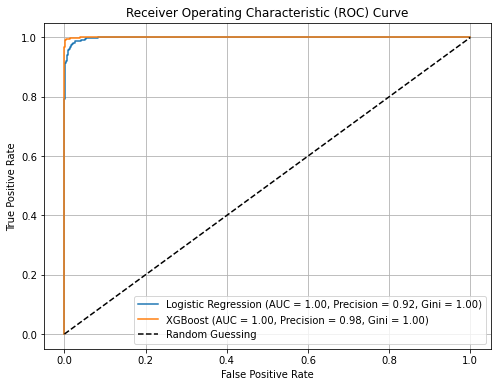

Logistic Regression:
AUC: 0.9983997105563441
Precision: 0.9186991869918699
Gini Coefficient: 0.9967994211126883
XGBoost:
AUC: 0.9998121399348752
Precision: 0.9829545454545454
Gini Coefficient: 0.9996242798697503


In [14]:
def evaluate_model_performance(y_true, y_pred_probs):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    
    # Calculate AUC (Area Under the Curve)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    
    # Calculate precision
    y_pred_labels = np.round(y_pred_probs)
    precision = precision_score(y_true, y_pred_labels)
    
    # Calculate Gini coefficient
    gini = 2 * roc_auc - 1
    
    return fpr, tpr, roc_auc, precision, gini
# Predict probabilities on the test set
lr_y_pred_probs = lr_model.predict_proba(X_test)[:, 1]
xgb_y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate logistic regression model performance
lr_fpr, lr_tpr, lr_roc_auc, lr_precision, lr_gini = evaluate_model_performance(y_test, lr_y_pred_probs)

# Evaluate XGBoost model performance
xgb_fpr, xgb_tpr, xgb_roc_auc, xgb_precision, xgb_gini = evaluate_model_performance(y_test, xgb_y_pred_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_roc_auc:.2f}, Precision = {lr_precision:.2f}, Gini = {lr_gini:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_roc_auc:.2f}, Precision = {xgb_precision:.2f}, Gini = {xgb_gini:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print("Logistic Regression:")
print("AUC:", lr_roc_auc)
print("Precision:", lr_precision)
print("Gini Coefficient:", lr_gini)

print("XGBoost:")
print("AUC:", xgb_roc_auc)
print("Precision:", xgb_precision)
print("Gini Coefficient:", xgb_gini)

From the results above , we ccan observe that the xgbost model is performing better than the logistic regression , and its precision score is almost perfect

# Expected Loss

Although the xgboost model is our choice i decided to builld the expected loss model with boths models

In [15]:
def calculate_expected_loss(loan_properties, lr_model, xgb_model, recovery_rate=0.1):
    # Prepare the loan data for prediction (exclude customer_id and default columns)
    loan_data = pd.DataFrame([loan_properties])
    
    # Predict the probability of default using logistic regression
    lr_prob_default = lr_model.predict_proba(loan_data)[:, 1]
    
    # Predict the probability of default using XGBoost
    xgb_prob_default = xgb_model.predict_proba(loan_data)[:, 1]
    
    # Calculate the expected loss using both models and the recovery rate
    expected_loss_lr = lr_prob_default * (1 - recovery_rate)
    expected_loss_xgb = xgb_prob_default * (1 - recovery_rate)
    
    return expected_loss_lr[0], expected_loss_xgb[0]

the next line is the loan properties of a customer , its informaton will be take and output the expect loss

In [19]:
loan_properties = {
    'credit_lines_outstanding': 2,
    'loan_amt_outstanding': 30000,
    'total_debt_outstanding': 4000,
    'income': 50000,
    'years_employed': 3,
    'fico_score': 750,
}
# Example of how to use the function with the trained models
expected_loss_lr, expected_loss_xgb = calculate_expected_loss(loan_properties, lr_model, xgb_model, recovery_rate=0.1)
print(f"Expected Loss on the loan (Logistic Regression): {expected_loss_lr:.2f}")
print(f"Expected Loss on the loan (XGBoost): {expected_loss_xgb:.2f}")

Expected Loss on the loan (Logistic Regression): 0.90
Expected Loss on the loan (XGBoost): 0.00


Both model give largely different expected loss , We found that ot xgboost have more precision so we may chosse to only work with xgbosst model . However I decided to check how different they really are by plotting they predcted probability of default and have their overall expected loss and found their average scores

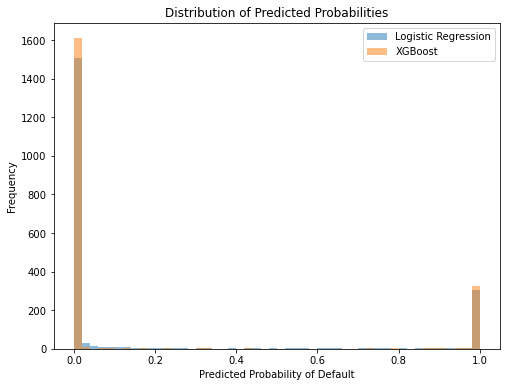

In [41]:
def plot_predicted_probabilities(lr_y_pred_probs, xgb_y_pred_probs):
    plt.figure(figsize=(8, 6))
    plt.hist(lr_y_pred_probs, bins=50, alpha=0.5, label='Logistic Regression')
    plt.hist(xgb_y_pred_probs, bins=50, alpha=0.5, label='XGBoost')
    plt.xlabel('Predicted Probability of Default')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.show()
plot_predicted_probabilities(lr_y_pred_probs, xgb_y_pred_probs)

In [219]:
X = df.drop(columns=['default'])
y = df['default']
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply scaling to the data before training the model
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_prob_default = cross_val_predict(lr_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
xgb_prob_default = cross_val_predict(xgb_model, X, y, cv=cv, method='predict_proba')[:, 1]
recovery_rate = 0.1
expected_loss_lr = lr_prob_default * (1 - recovery_rate)
expected_loss_xgb = xgb_prob_default * (1 - recovery_rate)

In [220]:
# Display the expected losses
print("Expected Loss on the loan (Logistic Regression):")
print(expected_loss_lr)

print("Expected Loss on the loan (XGBoost):")
print(expected_loss_xgb)


Expected Loss on the loan (Logistic Regression):
[2.11519713e-11 8.99999773e-01 1.52470252e-10 ... 1.10838165e-04
 9.33623872e-09 4.24493459e-09]
Expected Loss on the loan (XGBoost):
[2.0293410e-06 8.9967275e-01 2.2588465e-06 ... 1.4399581e-04 8.5216088e-06
 3.2018605e-05]


In [221]:
# Overall Expected Loss on the loan (Logistic Regression):
overall_expected_loss_lr = expected_loss_lr.mean()
print("Overall Expected Loss on the loan (Logistic Regression):")
print(overall_expected_loss_lr)

# Overall Expected Loss on the loan (XGBoost):
overall_expected_loss_xgb = expected_loss_xgb.mean()
print("Overall Expected Loss on the loan (XGBoost):")
print(overall_expected_loss_xgb)

Overall Expected Loss on the loan (Logistic Regression):
0.16657090044042938
Overall Expected Loss on the loan (XGBoost):
0.1662873


# Summary

At the end of the project , we learn that the probability that a customer default have a bit of correlation with with outsanding balances . Logistic egresion even with it supervised ML classifcation advantage does not outperform the Xgbosst model, whcich can be because xgboost ave some optimization technique and also take care of overfitting. With different expected loss , the model validation team may have a difficult choice to decided which moel use , but we may decided to use others model evaluation metric and do more back stress test

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Define the quantization boundaries for 5 buckets
low_risk_boundary = 300
high_risk_boundary = 850
bucket_width = (high_risk_boundary - low_risk_boundary) / 5
bucket_boundaries = [low_risk_boundary + i * bucket_width for i in range(6)]

# Function to calculate MSE
def calculate_mse(df, boundaries):
    # Create a label encoder to convert string labels to numerical values
    label_encoder = LabelEncoder()
    df["quantized_fico"] = pd.cut(df["fico_score"], bins=boundaries, labels=["Bucket 1", "Bucket 2", "Bucket 3", "Bucket 4", "Bucket 5"])
    df["quantized_fico_encoded"] = label_encoder.fit_transform(df["quantized_fico"])
    mse = mean_squared_error(df["default"], df["quantized_fico_encoded"])
    return mse

# Calculate initial MSE
initial_mse = calculate_mse(df, bucket_boundaries)
print(f"Initial MSE: {initial_mse:.2f}")

Initial MSE: 6.34


In [31]:
# Define a function to iteratively adjust boundaries and calculate MSE
def find_optimal_boundaries(df, max_iterations=100):
    current_boundaries = bucket_boundaries
    best_mse = initial_mse
    best_boundaries = current_boundaries.copy()
    
    for iteration in range(max_iterations):
        # Generate potential boundary candidates (e.g., adjust boundaries)
        boundary_candidates = current_boundaries.copy()
        for i in range(1, len(boundary_candidates) - 1):
            boundary_candidates[i] += 1  # Adjust boundaries
        
        # Calculate MSE for the candidates
        mse_values = []
        for candidate in boundary_candidates:
            mse = calculate_mse(df, boundary_candidates)
            mse_values.append(mse)
        
        # Find the best candidate
        best_candidate_idx = np.argmin(mse_values)
        best_candidate_mse = mse_values[best_candidate_idx]
        best_candidate_boundary = boundary_candidates[best_candidate_idx]
        
        # If the best candidate has a lower MSE, update boundaries
        if best_candidate_mse < best_mse:
            best_mse = best_candidate_mse
            best_boundaries = boundary_candidates
            current_boundaries = best_boundaries
        else:
            break
    
    return best_boundaries, best_mse

# Find optimal boundaries
optimal_boundaries, optimal_mse = find_optimal_boundaries(df)

# Print the optimal boundaries and corresponding MSE
print(f"Optimal Boundaries: {optimal_boundaries}")
print(f"Optimal MSE: {optimal_mse:.2f}")


Optimal Boundaries: [300.0, 510.0, 620.0, 730.0, 840.0, 850.0]
Optimal MSE: 2.84


In [33]:
# Define a function to iteratively adjust boundaries and calculate MSE
def find_optimal_boundaries(df, max_iterations=500):
    current_boundaries = bucket_boundaries
    best_mse = initial_mse
    best_boundaries = current_boundaries.copy()
    
    for iteration in range(max_iterations):
        # Generate potential boundary candidates (e.g., adjust boundaries)
        boundary_candidates = current_boundaries.copy()
        for i in range(1, len(boundary_candidates) - 1):
            boundary_candidates[i] += 1  # Adjust boundaries
        
        # Check if the boundaries are unique
        if len(set(boundary_candidates)) != len(boundary_candidates):
            break
        
        # Calculate MSE for the candidates
        mse_values = []
        for candidate in boundary_candidates:
            mse = calculate_mse(df, boundary_candidates)
            mse_values.append(mse)
        
        # Find the best candidate
        best_candidate_idx = np.argmin(mse_values)
        best_candidate_mse = mse_values[best_candidate_idx]
        best_candidate_boundary = boundary_candidates[best_candidate_idx]
        
        # If the best candidate has a lower MSE, update boundaries
        if best_candidate_mse < best_mse:
            best_mse = best_candidate_mse
            best_boundaries = boundary_candidates
            current_boundaries = best_boundaries
        else:
            break
    
    return best_boundaries, best_mse

# Find optimal boundaries
optimal_boundaries, optimal_mse = find_optimal_boundaries(df)

# Print the optimal boundaries and corresponding MSE
print(f"Optimal Boundaries: {optimal_boundaries}")
print(f"Optimal MSE: {optimal_mse:.2f}")


Optimal Boundaries: [300.0, 519.0, 629.0, 739.0, 849.0, 850.0]
Optimal MSE: 2.60
